In [171]:
import healpy as hp
import matplotlib.pyplot as plt
import src.sky_models as SM
import numpy as np
from scipy.optimize import minimize
from scipy.linalg import svd

from pygdsm import GlobalSkyModel2016

from src.spherical_harmonics import RealSphericalHarmonics
RS = RealSphericalHarmonics()

In [2]:
def splitvec(vec, nsplit):
    """
    Split a vector of length m into nsplit pieces, returning an array of shape
    nsplit x (m/nsplit).
    """
    if len(vec)%nsplit:
        raise ValueError("nsplit must divide vector length.")
    newvec = np.reshape(a=vec, newshape=(nsplit, int(len(vec)/nsplit)))
    return newvec

In [3]:
# Check the foreground generation is working.
nside = 32
lmax  = 64

nuarr = np.linspace(50,100,51)
a, mp = SM.foreground_gsma_alm(nu=nuarr, map=True, lmax=lmax, nside=nside)
a_sep = splitvec(a, len(nuarr))
np.shape(a_sep)

/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


(51, 4225)

In [4]:
# Make all alm curves non-negative.
negs = np.where(a_sep[0,:] < 0, True, False)
a_nonneg = np.array(a_sep)
a_nonneg[:,negs] = -a_nonneg[:,negs]

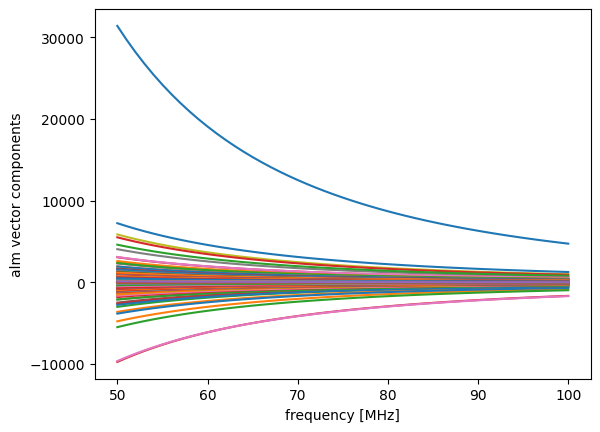

In [5]:
plt.plot(nuarr, a_sep)
plt.xlabel("frequency [MHz]")
plt.ylabel("alm vector components")
plt.show()

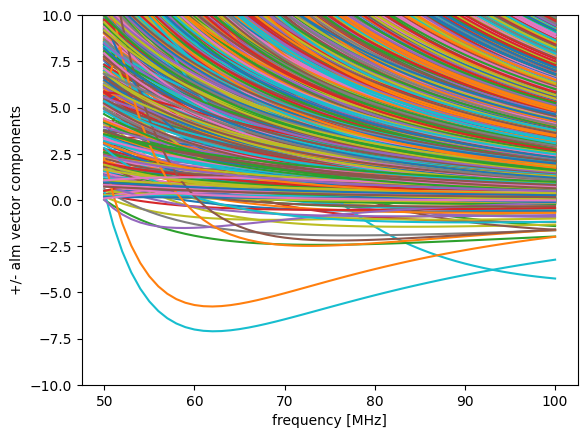

In [6]:
plt.plot(nuarr, a_nonneg)
plt.xlabel("frequency [MHz]")
plt.ylabel("+/- alm vector components")
plt.ylim(-10,10)
plt.show()

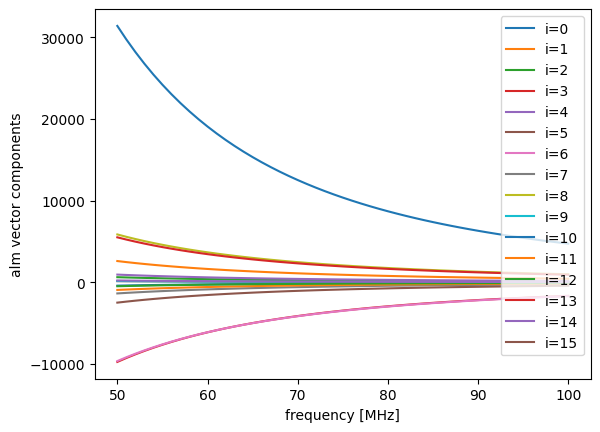

In [7]:
# Let's restrict attention to the low order alms.
lcut = 3
icut = RS.get_size(lcut)
label = [f"i={i}" for i in range(icut)]
plt.plot(nuarr, a_sep[:,:icut], label=label)
plt.xlabel("frequency [MHz]")
plt.ylabel("alm vector components")
plt.legend(loc='upper right')
plt.show()

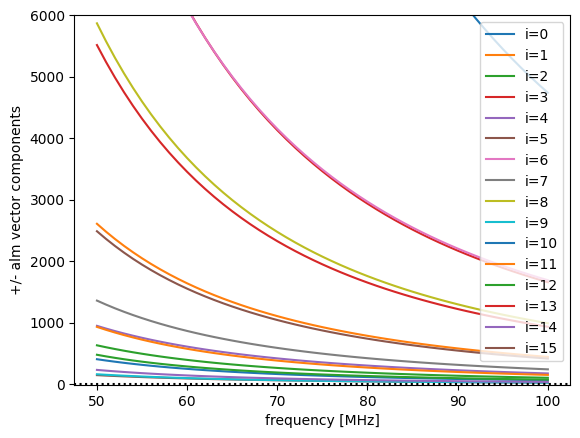

In [8]:
plt.plot(nuarr, a_nonneg[:,:icut], label=label)
plt.xlabel("frequency [MHz]")
plt.ylabel("+/- alm vector components")
plt.ylim(-10, 6000)
plt.axhline(0, linestyle=':', color='k')
plt.legend()
plt.show()

In [9]:
a_sep_compl = [RS.real2ComplexALM(almr) for almr in a_sep]
cls = [hp.sphtfunc.alm2cl(almc) for almc in a_sep_compl]

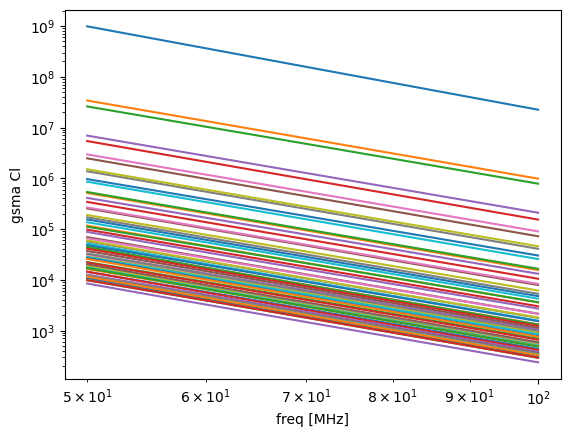

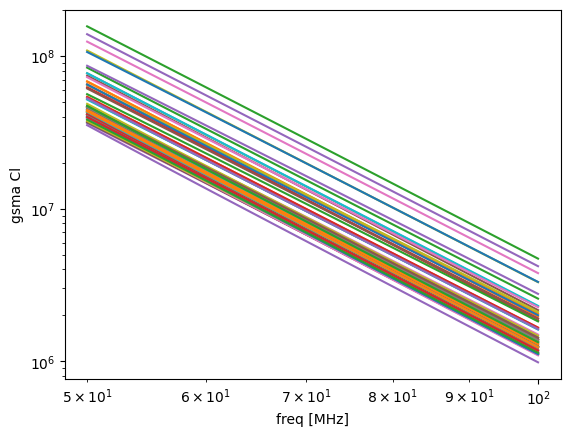

In [98]:
norm = np.array([l*(l+1) for l in range(lmax+1)])
cls_llp1 = np.array(cls) * norm
plt.loglog(nuarr, cls)
plt.xlabel('freq [MHz]')
plt.ylabel('gsma Cl')
plt.show()
plt.loglog(nuarr, cls_llp1)
plt.xlabel('freq [MHz]')
plt.ylabel('gsma Cl')
plt.show()

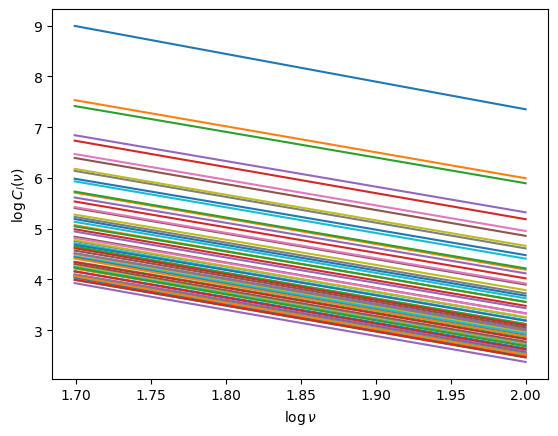

In [103]:
nuarr_log = np.log10(nuarr)
cls_log = np.log10(cls)
plt.plot(nuarr_log, cls_log)
plt.xlabel(r'$\log \nu$')
plt.ylabel(r'$\log C_l(\nu)$')
plt.show()

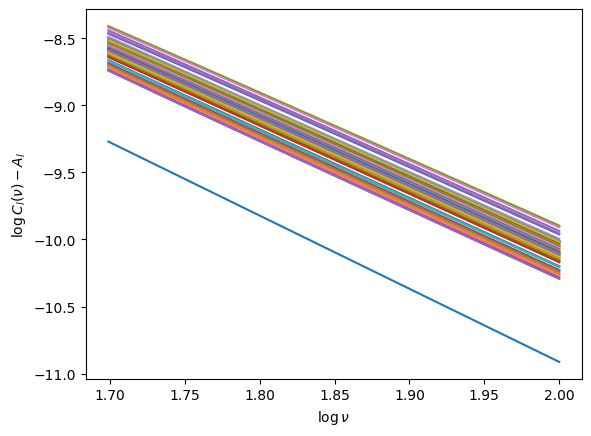

In [107]:
gammas, amplitudes = np.polyfit(nuarr_log, cls_log, deg=1)

cls_log_amplcorr = cls_log-amplitudes

plt.plot(nuarr_log, cls_log_amplcorr)
plt.xlabel(r'$\log \nu$')
plt.ylabel(r'$\log C_l(\nu) - A_l$')
plt.show()

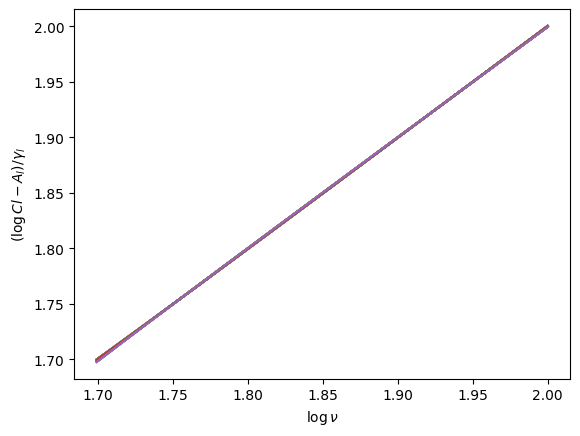

In [108]:
cls_log_corr = cls_log_amplcorr/gammas

plt.plot(nuarr_log, cls_log_corr)
plt.xlabel(r'$\log \nu$')
plt.ylabel(r'$( \log Cl - A_l ) / \gamma_l$')
plt.show()

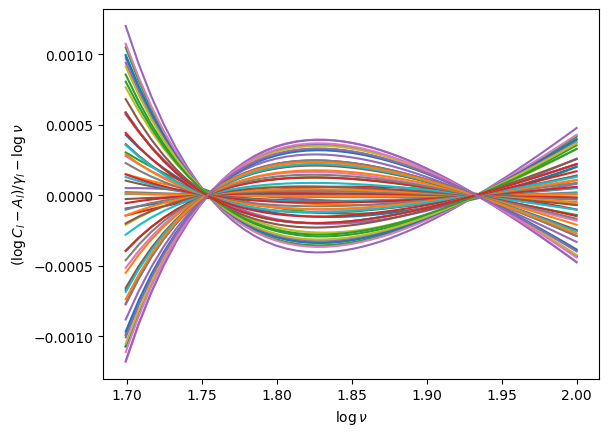

In [109]:
cls_log_corr_flat = cls_log_corr.T-nuarr_log
cls_log_corr_flat = cls_log_corr_flat.T

plt.plot(nuarr_log, cls_log_corr_flat)
plt.xlabel(r'$\log \nu$')
plt.ylabel(r'$( \log C_l - A_l ) / \gamma_l - \log\nu $')
plt.show()

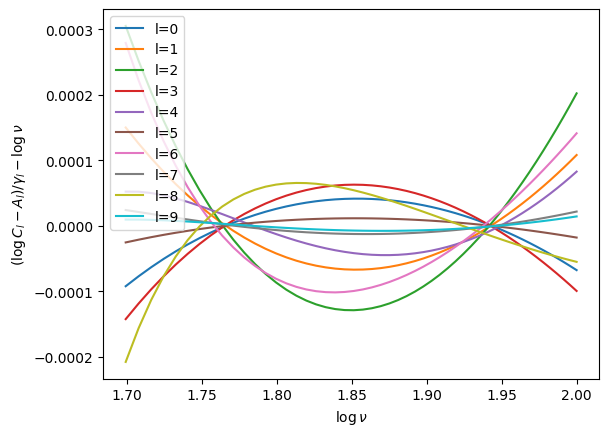

In [118]:
plt.plot(nuarr_log, cls_log_corr_flat[:,:10], label=[f"l={l}" for l in range(10)])
plt.xlabel(r'$\log \nu$')
plt.ylabel(r'$( \log C_l - A_l ) / \gamma_l - \log\nu $')
plt.legend()
plt.show()

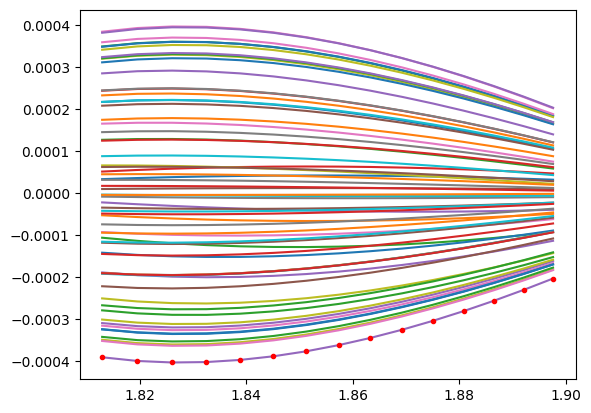

In [129]:
# Identify the smallest-amplitude line of all of them and collapse all other
# lines onto this one.
minval = np.where(cls_log_corr_flat[15:30] == np.min(cls_log_corr_flat[15:30]))
min_l = minval[1][0]
plt.plot(nuarr_log[15:30], cls_log_corr_flat[15:30])
plt.plot(nuarr_log[15:30], cls_log_corr_flat[15:30,min_l], '.', color='r')
plt.show()

In [150]:
fid_line = cls_log_corr_flat[:,min_l]
ds = []
lines = cls_log_corr_flat.T
for line in lines:
    minfunc = lambda d: np.sum((line - d*fid_line)**2)
    if line[0] < 0:
        x0 = -1
    else:
        x0 = 1
    fit = minimize(fun=minfunc, x0=x0, method='Nelder-Mead')
    ds.append(fit.x[0])
ds = np.array(ds)

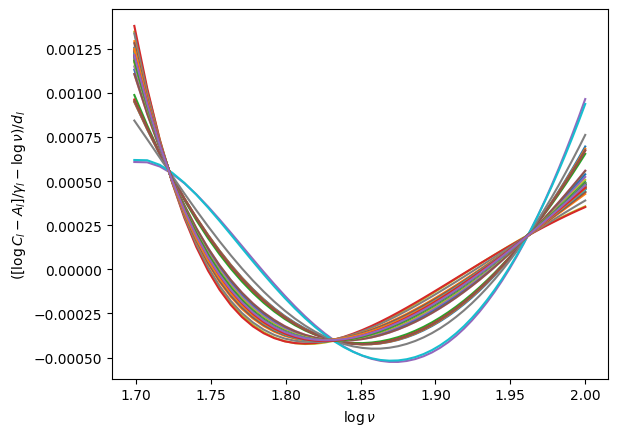

In [160]:
f_estimates = cls_log_corr_flat/ds
plt.plot(nuarr_log, f_estimates)
plt.xlabel(r'$\log \nu$')
plt.ylabel(r'$([\log C_l - A_l ] / \gamma_l - \log\nu)/d_l $')
plt.show()

In [199]:
np.shape(f_estimates)

(51, 65)

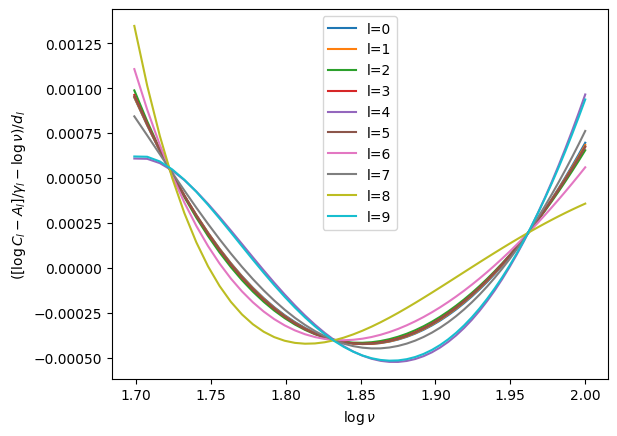

In [245]:
plt.plot(nuarr_log, f_estimates[:,:10], label=[f"l={l}" for l in range(10)])
plt.xlabel(r'$\log \nu$')
plt.ylabel(r'$([\log C_l - A_l ] / \gamma_l - \log\nu)/d_l $')
plt.legend()
plt.show()

In [246]:
def pca(arr, N, return_basis=False):
    """
    Represent the rows of an mxn array in an N-dimensional 
    coordinate system, where N < n.

    Returns
    -------
    coordinate matrix
        The rows of the matrix correspond to the coordinates
        of each row of arr in the reduced dimension space.
    basis matrix (if return_basis is True)
        nxN matrix with columns representing the basis vectors of
        the decomposition.
    """
    # Carry out SVD.
    U, S, Vh = svd(arr, full_matrices=False)

    # Truncate the SVD matrices.
    u_matrix = U[:,:N]
    singular_matrix = np.diag(S[:N])

    # Compute the coordinate matrix.
    coordinate_matrix = u_matrix @ singular_matrix
    
    if return_basis:
        basis_matrix = Vh[:N].T
        return coordinate_matrix, basis_matrix
    return coordinate_matrix


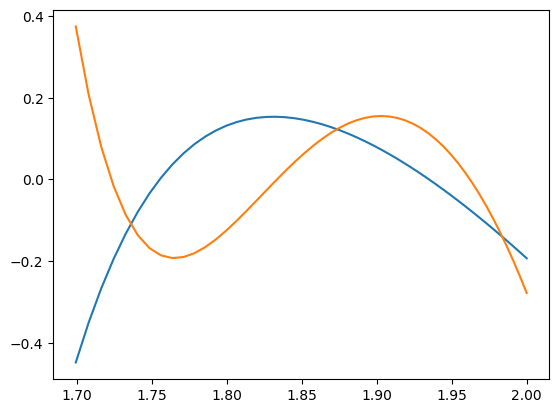

In [247]:
f_estimate_mat = f_estimates.T
coords, basis = pca(f_estimate_mat, N=2, return_basis=True)
plt.plot(nuarr_log, basis)
plt.show()

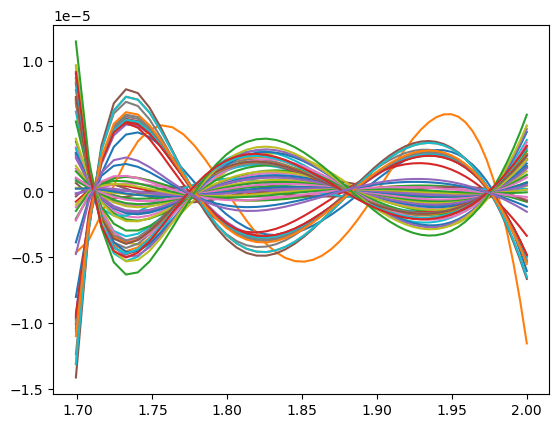

In [248]:
# Reconstruct the l modes using the first N SVD modes.
reconstruct = basis@coords.T
plt.plot(nuarr_log, reconstruct-f_estimates)
plt.show()

There is the question of: does adding a scaling parameter d before carrying out
PCA improve performance over just letting PCA do its thing? It costs us an extra
parameter, so it should be performing better than PCA plus one parameter in the
unscaled case.